# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
btc_balance = 5
eth_balance = 100

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price']
# Fetch current ETH price
eth_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * btc_balance
my_eth_value = eth_price * eth_balance

# Print current crypto wallet balance
print(f"The current value of your {btc_balance} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {eth_balance} ETH is ${my_eth_value:0.2f}")

The current value of your 5 BTC is $183655.00
The current value of your 100 ETH is $196793.00


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
key = os.getenv("ALPACA_API_KEY")
secret = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
alpaca_api = tradeapi.REST(
    key,
    secret,
    api_version="v2"
)

In [8]:
# Format current date as ISO format
date = pd.Timestamp('2023-11-17', tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca_api.get_bars(
    tickers,
    timeframe,
    start = date,
    end = date,
    limit=10000
).df

df_portfolio.head()

# Reorganize the DataFrame
# Separate ticker data
agg_df = df_portfolio[df_portfolio['symbol'] == 'AGG'].drop('symbol', axis='columns')
spy_df = df_portfolio[df_portfolio['symbol'] == 'SPY'].drop('symbol', axis='columns')

# Concatenate the ticker DataFrames
combined_df = pd.concat([agg_df, spy_df], axis='columns', keys=tickers)

# Preview DataFrame
combined_df.head()

AGG                                             \
                           close   high     low trade_count   open   volume   
timestamp                                                                     
2023-11-17 05:00:00+00:00  95.25  95.36  95.025       27266  95.21  9244030   

                                         SPY                              \
                                vwap   close    high     low trade_count   
timestamp                                                                  
2023-11-17 05:00:00+00:00  95.213371  450.79  451.42  449.29      439332   

                                                         
                             open    volume        vwap  
timestamp                                                
2023-11-17 05:00:00+00:00  450.24  83183079  450.530471

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(combined_df["AGG"]["close"].iloc[0])
spy_close_price = float(combined_df["SPY"]["close"].iloc[0])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $95.25
Current SPY closing price: $450.79


In [10]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22539.50
The current value of your 200 AGG shares is $19050.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 40000.00

# Consolidate financial assets data
consolidated_assets = {'Amount': [my_btc_value + my_eth_value, my_spy_value + my_agg_value]}

# Create savings DataFrame
savings = {
    "value": [my_spy_value, my_agg_value, my_btc_value, my_eth_value],
    "shares": [my_agg, my_spy, btc_balance, eth_balance]
}

df_savings = pd.DataFrame(data=savings, index=['spy', 'agg', 'btc', 'eth'])

# Display savings DataFrame
display(df_savings)

,value,shares
spy,22539.5,200
agg,19050.0,50
btc,183655.0,5
eth,196793.0,100


<Axes: title={'center': 'Crypto Positions Value (USD)'}, ylabel='value'>

<Axes: title={'center': 'Crypto Positions Shares'}, ylabel='shares'>

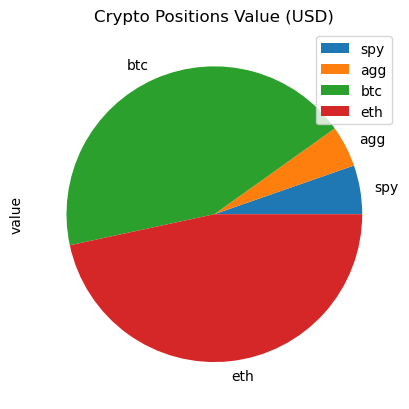

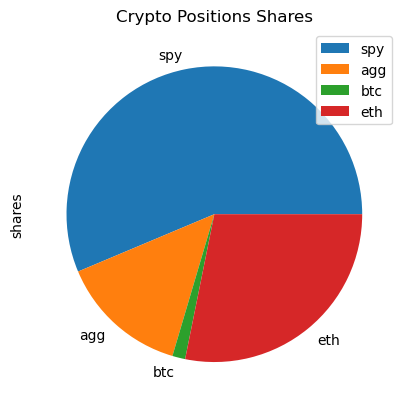

In [12]:
# Plot savings pie chart
display(df_savings.plot(kind='pie', y='value', title='Crypto Positions Value (USD)'))
display(df_savings.plot(kind='pie', y='shares', title='Crypto Positions Shares'))

In [13]:
# Set ideal emergency fund
n_months = 12
emergency_fund = monthly_income * n_months

# Calculate total amount of savings
total_savings = df_savings['value'].sum()
total_savings

# Validate saving health
if total_savings > emergency_fund:
    print(f"Excellent: total savings is {round(total_savings/monthly_income)}x your monthly income")
elif total_savings == emergency_fund:
    print(f"Good: Total savings is exactly {n_months}x monthly income")
else:
    print(f"Okay ${emergency_fund-total_savings} left to hit savings goal")

Okay $57962.5 left to hit savings goal


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
start_date = pd.Timestamp('2018-11-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-11-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca_api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit=10000
).df

# Reorganize the DataFrame
# Separate ticker data
agg_df = df_stock_data[df_stock_data['symbol'] == 'AGG'].drop('symbol', axis='columns')
spy_df = df_stock_data[df_stock_data['symbol'] == 'SPY'].drop('symbol', axis='columns')

# Insert daily return col
agg_df.insert(7, 'daily_return', agg_df['close'].pct_change())
spy_df.insert(7, 'daily_return', spy_df['close'].pct_change())
              
# # Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_df, spy_df], axis='columns', keys=tickers)

# # Display sample data

df_stock_data.index = df_stock_data.index.date
df_stock_data.sample(2)

AGG                                                            \
             close    high      low trade_count    open   volume        vwap   
2023-08-23   96.15   96.15   95.731       31730   95.75  7831606   96.008053   
2021-05-27  114.55  114.62  114.450       26900  114.61  5345408  114.516436   

                            SPY                                        \
           daily_return   close    high       low trade_count    open   
2023-08-23     0.009555  443.03  443.67  439.1000      469244  439.25   
2021-05-27    -0.001221  419.18  420.72  418.9851      398541  420.17   

                                               
              volume        vwap daily_return  
2023-08-23  68441023  441.907016     0.011138  
2021-05-27  58438340  419.753626     0.000334

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
mc_result = MCSimulation(
    df_stock_data,
    [1/2,1/2],
    252*30
)

In [17]:
# Printing the simulation input data
mc_result.portfolio_data.tail()

AGG                                                            \
            close     high      low trade_count   open    volume       vwap   
2023-10-26  92.62  92.6400  92.1050       27445  92.12  11574571  92.372812   
2023-10-27  92.59  92.6405  92.3700       23149  92.56   7650175  92.523401   
2023-10-30  92.37  92.5050  92.1523       24457  92.29   8166711  92.338077   
2023-10-31  92.31  92.6300  92.3100       26970  92.45  12343606  92.470648   
2023-11-01  93.05  93.0500  92.2300       42085  92.23  14404642  92.761165   

                            SPY                                         \
           daily_return   close     high       low trade_count    open   
2023-10-26     0.006739  412.55  417.325  411.6000      846343  416.45   
2023-10-27    -0.000324  410.68  414.600  409.2100      800491  414.19   
2023-10-30    -0.002376  415.59  416.680  412.2200      638015  413.56   
2023-10-31    -0.000650  418.20  418.530  414.2100      563417  416.18   
2023-11-01     0.008016  422.66  423.500  418.6499      724433  419.20   

                                                
               volume        vwap daily_return  
2023-10-26  115156763  414.172145    -0.011975  
2023-10-27  107367673  411.578844    -0.004533  
2023-10-30   86562677  414.333841     0.011956  
2023-10-31   79665152  416.897896     0.006280  
2023-11-01   98068117  420.874607     0.010665

In [ ]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc_result.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

In [ ]:
# Plot simulation outcomes
mc_result.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
mc_result.plot_distribution()

### Retirement Analysis

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = mc_result.summarize_cumulative_return()

# Print summary statistics
summary_stats

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
outcome_range = (
    round(initial_investment * summary_stats[8],2), 
    round(initial_investment * summary_stats[9],2)
)
ci_lower, ci_upper = outcome_range
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [ ]:
# Set initial investment
initial_investment_2 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
outcome_range_2 = (
    round(initial_investment_2 * summary_stats[8],2), 
    round(initial_investment_2 * summary_stats[9],2)
)
ci_lower_2, ci_upper_2 = outcome_range_2

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_2} and ${ci_upper_2}")

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_5_yr = MCSimulation(
    df_stock_data,
    [1/2,1/2],
    252*5
)

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_5_yr.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
mc_5_yr.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
mc_5_yr.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats_5_yr = mc_5_yr.summarize_cumulative_return()
# Print summary statistics
summary_stats_5_yr

In [ ]:
# Set initial investment
initial_investment_3 = 15000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
return_range = (round(initial_investment_3 * summary_stats_5_yr[8]), round(initial_investment_3 * summary_stats_5_yr[9]))
ci_lower_3, ci_upper_3 = return_range

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_3} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_3} and ${ci_upper_3}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_10_yr = MCSimulation(
    df_stock_data,
    [1/2,1/2],
    252*10
)

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_10_yr.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
mc_10_yr.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
mc_10_yr.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats_10_yrs = mc_10_yr.summarize_cumulative_return()

# Print summary statistics
summary_stats_10_yrs

In [ ]:
# Set initial investment
initial_investment_4 = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
outcome_range = (initial_investment_4 * summary_stats_10_yrs[8], initial_investment_4 * summary_stats_10_yrs[9])
ci_lower_4, ci_upper_4 = outcome_range
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_4} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_4} and ${ci_upper_4}")